In [1]:
library(data.table)
library(ggplot2)
library(viridis)
library(patchwork)
library(reshape2)
library(gridExtra)
library(ggpubr)
library(ggrastr)
library(dplyr)

set.seed(42)
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}
get_density <- function(x, y, ...) {
    dens <- MASS::kde2d(x, y, ...)
    ix <- findInterval(x, dens$x)
    iy <- findInterval(y, dens$y)
    ii <- cbind(ix, iy)
    return(dens$z[ii])
  } 

Warning message:
“package ‘data.table’ was built under R version 4.3.3”
Loading required package: viridisLite

Warning message:
“package ‘viridisLite’ was built under R version 4.3.3”
Warning message:
“package ‘patchwork’ was built under R version 4.3.3”
Warning message:
“package ‘reshape2’ was built under R version 4.3.3”

Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Warning message:
“package ‘gridExtra’ was built under R version 4.3.3”
Warning message:
“package ‘ggrastr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, uni

In [2]:
meta_data <- read.csv("/home//workspace/IHA_Figure_Revision/Dataset/scRNA_meta_data-2024-05-09.csv")
df<-readr::read_csv('../Figure5/04_TCR_Stim_Exp/annotated1.csv')
df<-left_join(df,unique(meta_data[c('subjectGuid','CMV')]),
              by =c("donor"="subjectGuid"))

Rows: 6937027 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): condition, donor, time, group, cell_type, L1, L2, L3, L4, Final_Ce...
dbl (22): FSC, FSC-H, SSC, SSC-B, SSC-B-H, SSC-H, CCR7, IFNg, CD3, CD45RA, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
df_subset<-df%>% as.data.frame() %>% filter(L1=="CD4+", L2=="Memory",
                                            condition=="TCR",
                                 donor %in% c("BR1044","BR2036"))

In [8]:
x_intercept <- 3.3
y_intercept <- 3


df_subset$Group <- paste0(df_subset$condition, "-", df_subset$L1, " ", df_subset$L2, "-", df_subset$donor)
df_subset <- df_subset %>%
    group_by(Group) %>%
    mutate(density = get_density(IL4, IFNg, n = 100)) %>%
    ungroup()

df_subset <- df_subset %>%
    mutate(region = case_when(IL4 >= x_intercept & IFNg >= y_intercept ~ "Q1", 
                              IL4 < x_intercept & IFNg >= y_intercept ~ "Q2", 
                              IL4 < x_intercept & IFNg <
        y_intercept ~ "Q3", IL4 >= x_intercept & IFNg < y_intercept ~ "Q4"))

region_pct <- df_subset %>%
    group_by(Group, region) %>%
    summarise(percent = round(n()/nrow(df_subset[df_subset$Group == unique(Group), ]) * 100, 2), .groups = "drop")

corners <- df_subset %>%
    summarise(x_min = min(IL4), x_max = max(IL4), y_min = min(IFNg), y_max = max(IFNg)) %>%
    tidyr::crossing(region = c("Q1", "Q2", "Q3", "Q4")) %>%
    mutate(x = case_when(region == "Q1" ~ x_max, region == "Q2" ~ x_min, 
                         region == "Q3" ~ x_min, region == "Q4" ~ x_max), 
           y = case_when(region == "Q1" ~y_max, region == "Q2" ~ y_max, 
                         region == "Q3" ~ y_min, region == "Q4" ~ y_min), 
           offset = 0.12 * (x_max - x_min), x = ifelse(region %in% c("Q2","Q3"), 
                                                       x + offset, x - offset), 
           y = ifelse(region %in% c("Q3", "Q4"), 
                      y + offset, y - offset)) %>%select(region, x, y)

region_pct <- left_join(region_pct, corners, by = c("region"))
dens <- MASS::kde2d(df_subset$IL4, df_subset$IFNg, n = 100)

p <- ggplot(df_subset, aes(x = IL4, y = IFNg)) +
  theme(legend.position = "right") +
  # other regions (including Q4 density)
  geom_point_rast(
    data   = df_subset,
    aes(color = ifelse(region == "Q1", density, NA)),
    size   = 0.1,
    stroke = 0
  ) +
  # Q2 in blue, larger
  geom_point_rast(
    data   = subset(df_subset, region == "Q1"),
    aes(x = IL4, y = IFNg),
    size   = 0.7,
    color  = "#0072B2",
    stroke = 0) +
  scale_color_viridis(
    option   = "H",
    name     = "Density",
    direction = 1,
    na.value = "grey80") +
  geom_vline(xintercept = x_intercept,size = 0.3) +
  geom_hline(yintercept = y_intercept,size=0.3) +
  geom_text(
    data = region_pct,
    aes(x = x,
        y = y,
        label = paste0(percent, "%")),
    inherit.aes = FALSE,
    size = 2.1)+stat_density_2d(
  data   = df_subset,
  aes(x = IL4, y = IFNg),
  geom   = "contour",
  color  = "black",
  breaks = seq(0, max(dens$z), length.out = 40)[-1],  
  size   = 0.05
) +
  facet_wrap(~ Group, ncol = 2) +
  theme_minimal(base_size = 6) +
  theme(
    axis.title = element_text(color = "black"),
    axis.text  = element_text(color = "black"),
    legend.position = "none")



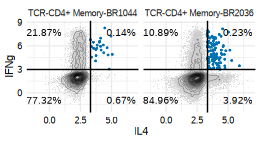

In [10]:
options(repr.plot.width = 55/25.4, repr.plot.height = 30/25.4)

p

ggsave("FigureE.pdf",
       p,
       width=55/25.4,
       height = 30/25.4)

In [11]:
df_subset<-df%>% as.data.frame() %>% filter(L1=="CD8+", L2=="Memory",condition=="TCR",
                                 donor %in% c("BR1044","BR2036"))

In [12]:
x_intercept <- 3.1
y_intercept <- 3


df_subset$Group <- paste0(df_subset$condition, "-", df_subset$L1, " ", df_subset$L2, "-", df_subset$donor)
df_subset <- df_subset %>%
    group_by(Group) %>%
    mutate(density = get_density(IL4, IFNg, n = 100)) %>%
    ungroup()

df_subset <- df_subset %>%
    mutate(region = case_when(IL4 >= x_intercept & IFNg >= y_intercept ~ "Q1", 
                              IL4 < x_intercept & IFNg >= y_intercept ~ "Q2", 
                              IL4 < x_intercept & IFNg <
        y_intercept ~ "Q3", IL4 >= x_intercept & IFNg < y_intercept ~ "Q4"))

region_pct <- df_subset %>%
    group_by(Group, region) %>%
    summarise(percent = round(n()/nrow(df_subset[df_subset$Group == unique(Group), ]) * 100, 2), .groups = "drop")

corners <- df_subset %>%
    summarise(x_min = min(IL4), x_max = max(IL4), y_min = min(IFNg), y_max = max(IFNg)) %>%
    tidyr::crossing(region = c("Q1", "Q2", "Q3", "Q4")) %>%
    mutate(x = case_when(region == "Q1" ~ x_max, region == "Q2" ~ x_min, 
                         region == "Q3" ~ x_min, region == "Q4" ~ x_max), 
           y = case_when(region == "Q1" ~y_max, region == "Q2" ~ y_max, 
                         region == "Q3" ~ y_min, region == "Q4" ~ y_min), 
           offset = 0.12 * (x_max - x_min), x = ifelse(region %in% c("Q2","Q3"), 
                                                       x + offset, x - offset), 
           y = ifelse(region %in% c("Q3", "Q4"), 
                      y + offset, y - offset)) %>%select(region, x, y)

region_pct <- left_join(region_pct, corners, by = c("region"))
dens <- MASS::kde2d(df_subset$IL4, df_subset$IFNg, n = 100)

p <- ggplot(df_subset, aes(x = IL4, y = IFNg)) +
  theme(legend.position = "right") +
  # other regions (including Q4 density)
  geom_point_rast(
    data   = df_subset,
    aes(color = ifelse(region == "Q1", density, NA)),
    size   = 0.1,
    stroke = 0
  ) +
  # Q2 in blue, larger
  geom_point_rast(
    data   = subset(df_subset, region == "Q1"),
    aes(x = IL4, y = IFNg),
    size   = 0.7,
    color  = "#0072B2",
    stroke = 0) +
  scale_color_viridis(
    option   = "H",
    name     = "Density",
    direction = 1,
    na.value = "grey80") +
  geom_vline(xintercept = x_intercept,size = 0.3) +
  geom_hline(yintercept = y_intercept,size=0.3) +
  geom_text(
    data = region_pct,
    aes(x = x,
        y = y,
        label = paste0(percent, "%")),
    inherit.aes = FALSE,
    size = 2.1)+stat_density_2d(
  data   = df_subset,
  aes(x = IL4, y = IFNg),
  geom   = "contour",
  color  = "black",
  breaks = seq(0, max(dens$z), length.out = 40)[-1],  
  size   = 0.05
) +
  facet_wrap(~ Group, ncol = 2) +
  theme_minimal(base_size = 6) +
  theme(
    axis.title = element_text(color = "black"),
    axis.text  = element_text(color = "black"),
    legend.position = "none")



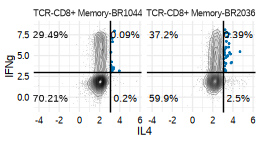

In [13]:
options(repr.plot.width = 55/25.4, repr.plot.height = 30/25.4)

p

ggsave("FigureE.pdf",
       p,
       width=55/25.4,
       height = 30/25.4)